In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pyod.models.gmm import GMM

normal_path = "features/S01/1/Normal/c_data"
relay_path  = "features/S01/1/Relay/c_data"

with h5py.File("datasets/features_S01_combined.h5", "r") as f:
    normal_group = f[normal_path]
    relay_group  = f[relay_path]

    n_norm = normal_group["0"].shape[0]
    n_relay = relay_group["0"].shape[0]

    dataset_normal = np.zeros((49997, n_norm))
    dataset_relay  = np.zeros((49998, n_relay))

    for i in range(49997):
        try:
            dataset_normal[i] = normal_group[str(i)][:]
        except KeyError:
            continue

    for i in range(49998):
        try:
            dataset_relay[i] = relay_group[str(i)][:]
        except KeyError:
            continue

scalerMinMax = MinMaxScaler()
scalerStandard = StandardScaler()

X_train               = dataset_normal[:47500]
X_test_normal         = dataset_normal[47500:]
X_test_relay          = dataset_relay[47500:]

scalerMinMax.fit(X_train)
X_train_scaled_minmax       = scalerMinMax.transform(X_train)
X_test_norm_scaled_minmax   = scalerMinMax.transform(X_test_normal)
X_test_relay_scaled_minmax  = scalerMinMax.transform(X_test_relay)

scalerStandard.fit(X_train)
X_train_scaled_standard        = scalerStandard.transform(X_train)
X_test_norm_scaled_standard    = scalerStandard.transform(X_test_normal)
X_test_relay_scaled_standard   = scalerStandard.transform(X_test_relay)

X_test_combined = np.vstack((X_test_normal, X_test_relay))
X_test_combined_scaled_minmax = np.vstack((X_test_norm_scaled_minmax, X_test_relay_scaled_minmax))
X_test_combined_scaled_standard = np.vstack((X_test_norm_scaled_standard, X_test_relay_scaled_standard))

y_true = np.array([0] * len(X_test_normal) + [1] * len(X_test_relay))

components 30

Classification Report:
               precision    recall  f1-score   support

      Normal       0.68      0.94      0.79      2497
       Relay       0.90      0.55      0.69      2498

    accuracy                           0.75      4995
   macro avg       0.79      0.75      0.74      4995
weighted avg       0.79      0.75      0.74      4995



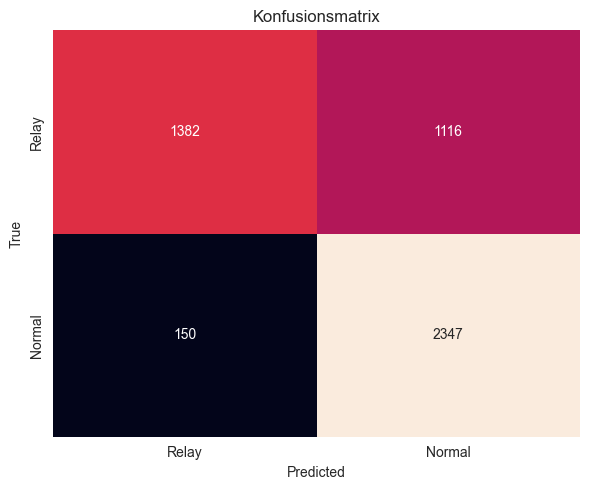

In [6]:

clf = GMM(contamination=0.01, n_components=50, max_iter=500)
clf.fit(X_train)

# pyod.predict: 0 = inlier, 1 = outlier
y_pred = clf.predict(X_test_combined)

# cm und report
cm = confusion_matrix(y_true, y_pred, labels=[1,0])
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

# plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Relay","Normal"],
            yticklabels=["Relay","Normal"],
            cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Konfusionsmatrix")
plt.tight_layout()
plt.show()

components 30

Classification Report:
               precision    recall  f1-score   support

      Normal       0.71      0.91      0.80      2497
       Relay       0.87      0.64      0.74      2498

    accuracy                           0.77      4995
   macro avg       0.79      0.77      0.77      4995
weighted avg       0.79      0.77      0.77      4995



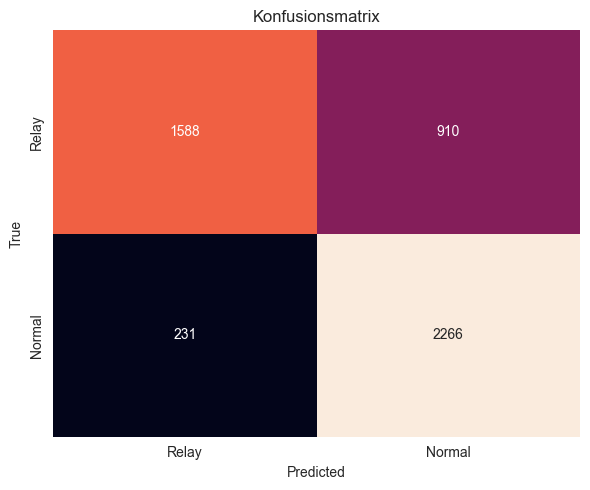

In [7]:

clf = GMM(contamination=0.01, n_components=80, max_iter=500)
clf.fit(X_train)

# pyod.predict: 0 = inlier, 1 = outlier
y_pred = clf.predict(X_test_combined)

# cm und report
cm = confusion_matrix(y_true, y_pred, labels=[1,0])
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

# plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Relay","Normal"],
            yticklabels=["Relay","Normal"],
            cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Konfusionsmatrix")
plt.tight_layout()
plt.show()

components 1

Classification Report:
               precision    recall  f1-score   support

      Normal       0.56      0.99      0.71      2497
       Relay       0.95      0.23      0.36      2498

    accuracy                           0.61      4995
   macro avg       0.75      0.61      0.54      4995
weighted avg       0.75      0.61      0.54      4995



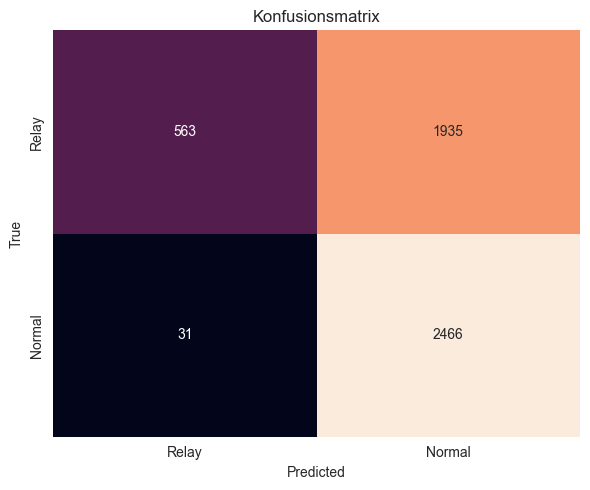

components 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.55      0.99      0.70      2497
       Relay       0.94      0.18      0.30      2498

    accuracy                           0.58      4995
   macro avg       0.74      0.58      0.50      4995
weighted avg       0.74      0.58      0.50      4995



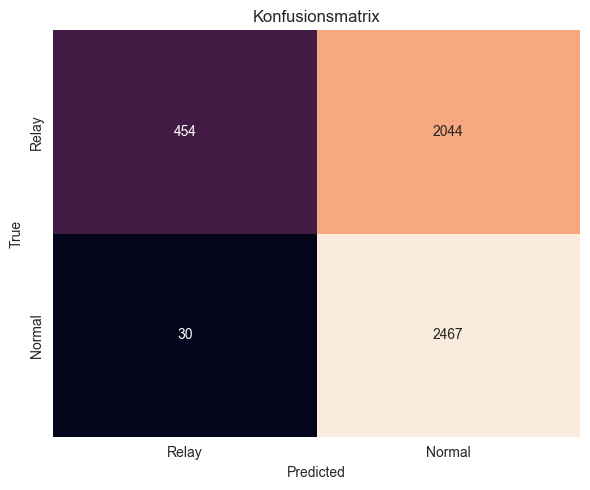

components 5

Classification Report:
               precision    recall  f1-score   support

      Normal       0.54      0.99      0.70      2497
       Relay       0.93      0.16      0.27      2498

    accuracy                           0.57      4995
   macro avg       0.74      0.57      0.48      4995
weighted avg       0.74      0.57      0.48      4995



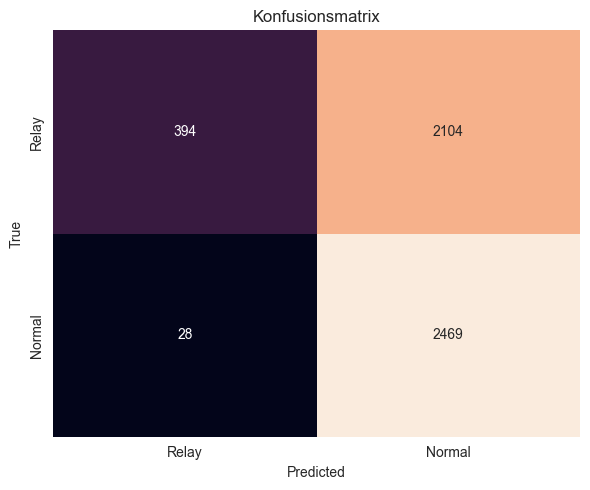

components 30

Classification Report:
               precision    recall  f1-score   support

      Normal       0.58      0.98      0.73      2497
       Relay       0.93      0.29      0.45      2498

    accuracy                           0.64      4995
   macro avg       0.76      0.64      0.59      4995
weighted avg       0.76      0.64      0.59      4995



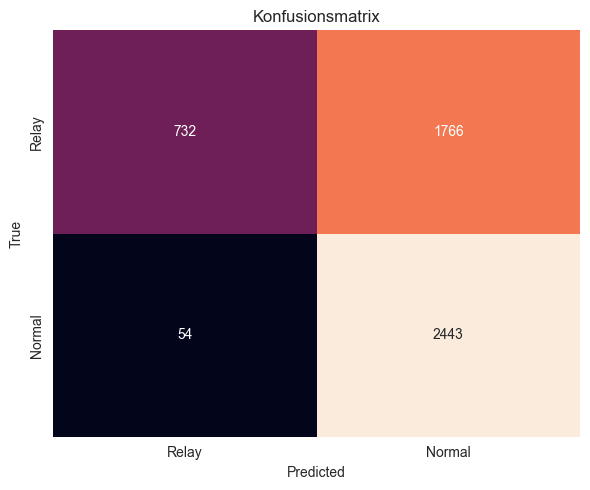

In [3]:
for n in {1,5,10,30}:
    clf = GMM(contamination=0.01, n_components=n)
    clf.fit(X_train_scaled_standard)

    # pyod.predict: 0 = inlier, 1 = outlier
    y_pred = clf.predict(X_test_combined_scaled_standard)

    # cm und report
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    print(f"components {n}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

    # plot
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=["Relay","Normal"],
                yticklabels=["Relay","Normal"],
                cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Konfusionsmatrix")
    plt.tight_layout()
    plt.show()

components 1

Classification Report:
               precision    recall  f1-score   support

      Normal       0.56      0.99      0.71      2497
       Relay       0.95      0.21      0.35      2498

    accuracy                           0.60      4995
   macro avg       0.75      0.60      0.53      4995
weighted avg       0.75      0.60      0.53      4995



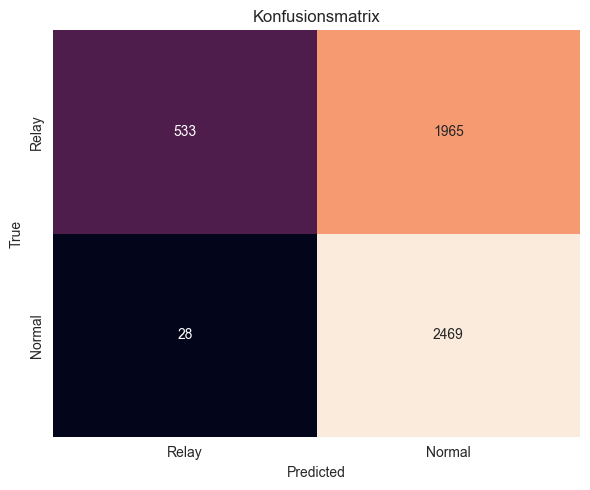

components 10

Classification Report:
               precision    recall  f1-score   support

      Normal       0.54      0.99      0.70      2497
       Relay       0.92      0.16      0.27      2498

    accuracy                           0.57      4995
   macro avg       0.73      0.57      0.49      4995
weighted avg       0.73      0.57      0.49      4995



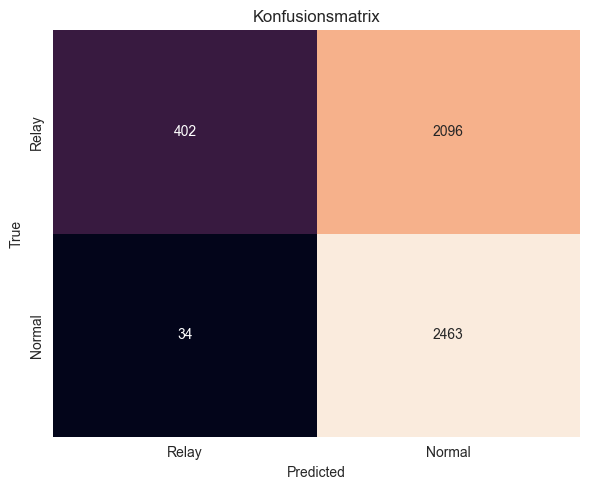

components 5

Classification Report:
               precision    recall  f1-score   support

      Normal       0.53      0.99      0.69      2497
       Relay       0.92      0.13      0.22      2498

    accuracy                           0.56      4995
   macro avg       0.72      0.56      0.46      4995
weighted avg       0.72      0.56      0.46      4995



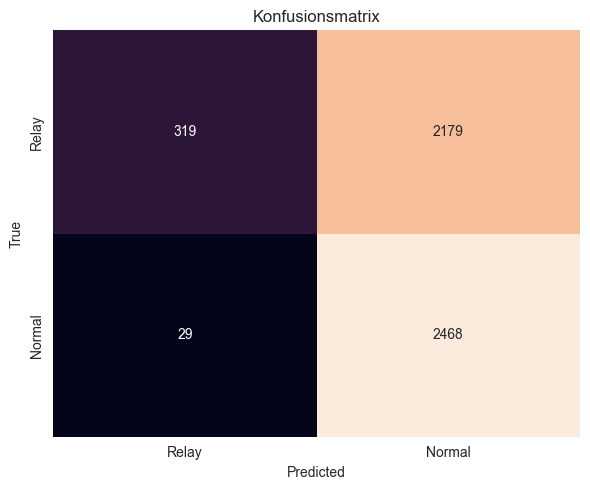

components 30

Classification Report:
               precision    recall  f1-score   support

      Normal       0.55      0.98      0.71      2497
       Relay       0.93      0.21      0.34      2498

    accuracy                           0.60      4995
   macro avg       0.74      0.60      0.53      4995
weighted avg       0.74      0.60      0.53      4995



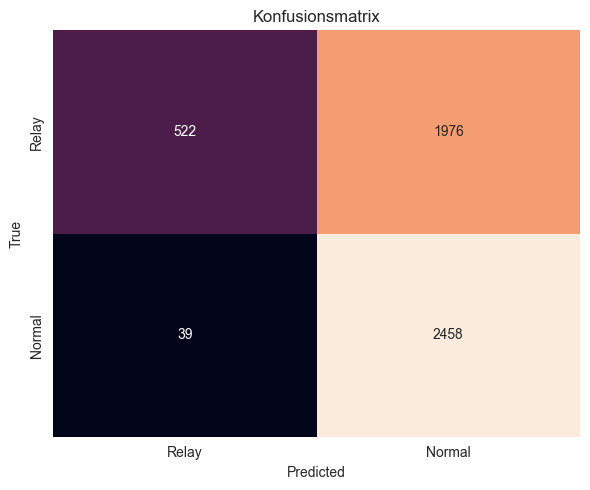

In [4]:
for n in {1,5,10,30}:
    clf = GMM(contamination=0.01, n_components=n)
    clf.fit(X_train_scaled_minmax)

    # pyod.predict: 0 = inlier, 1 = outlier
    y_pred = clf.predict(X_test_combined_scaled_minmax)

    # cm und report
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    print(f"components {n}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

    # plot
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=["Relay","Normal"],
                yticklabels=["Relay","Normal"],
                cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Konfusionsmatrix")
    plt.tight_layout()
    plt.show()